In [1]:
from setup.voxel_setup import setup_voxel_scene
from simulation.simulator import compute_ior_gradient, generate_initial_wavefront, simulate_wavefront_propagation, remove_under_floor
from common.plot import Plotter
from data.octree import Octree
from data.mlp import MLP

import taichi as ti
from scipy import ndimage

# debug=True to check boundary access
ti.init(arch=ti.gpu)

%load_ext autoreload
%autoreload 2

%matplotlib widget

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] Starting on arch=cuda


## 1. Load voxel model

In [2]:
NUM_X, NUM_Y, NUM_Z = 128, 128, 128
scene, floor_height = setup_voxel_scene(NUM_X, NUM_Y, NUM_Z)

Loaded Voxel shape: (128, 128, 128)  from: ./assets/bun_zipper_res4.ply
Number of filled voxels: 13849
Loaded Voxel shape: (128, 128, 128)  from: ./assets/wine_glass.obj
Number of filled voxels: 9035
Floor Ratio: -0.3125 , Floor Height: 44


## 2. Path tracing render

In [3]:
scene.finish()

## 3. Perform light simulation

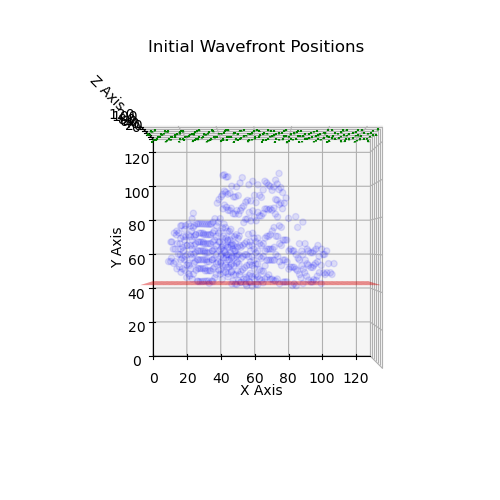

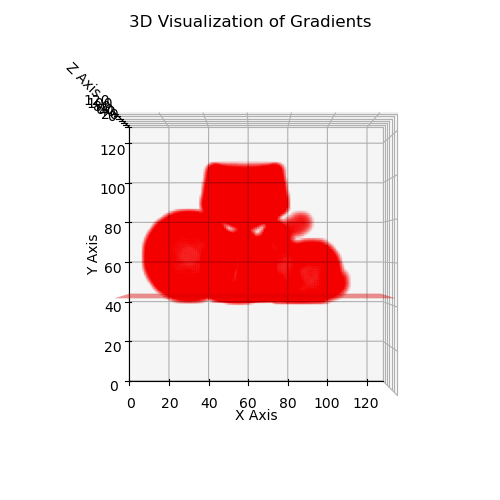

In [4]:
assert scene.ior.shape == (NUM_X, NUM_Y, NUM_Z), "The scene IOR should be a NumPy array of shape (NUM_X, NUM_Y, NUM_Z)"

sampler_multiplier = 3
pos_perturbation_scale = 0.45
initial_wavefront_pos, initial_wavefront_dir = generate_initial_wavefront(sampler_multiplier, pos_perturbation_scale, NUM_X, NUM_Y, NUM_Z)

scene.ior = ndimage.gaussian_filter(scene.ior, sigma=3.0, radius=1)
scene.gradient = compute_ior_gradient(scene.ior)

plotter = Plotter(sampler_multiplier, floor_height, scene.ior)
plotter.plot_wavefront_position(initial_wavefront_pos, initial_wavefront_dir, title="Initial Wavefront Positions")
plotter.plot_gradient(scene.gradient, threshold=0.01, alpha=0.01)

In [5]:
test_delta_t = 0.3 * (NUM_Y / 100)
test_num_steps = int(1.1 * (NUM_Y / test_delta_t))
raw_irradiance, scene.local_diretion = simulate_wavefront_propagation(scene.ior, scene.gradient, scene.attenuation,
                                                initial_wavefront_pos, initial_wavefront_dir,
                                                plotter, test_num_steps, step_size=test_delta_t, num_show_images=0)

# plotter.plot_local_direction_grid_slices(scene.local_diretion, num_slices=8, z_start=30, z_end=120, stream_plot=False)
raw_irradiance = remove_under_floor(raw_irradiance, floor_height=floor_height)
scene.irradiance = ndimage.gaussian_filter(raw_irradiance, sigma=0.8) 

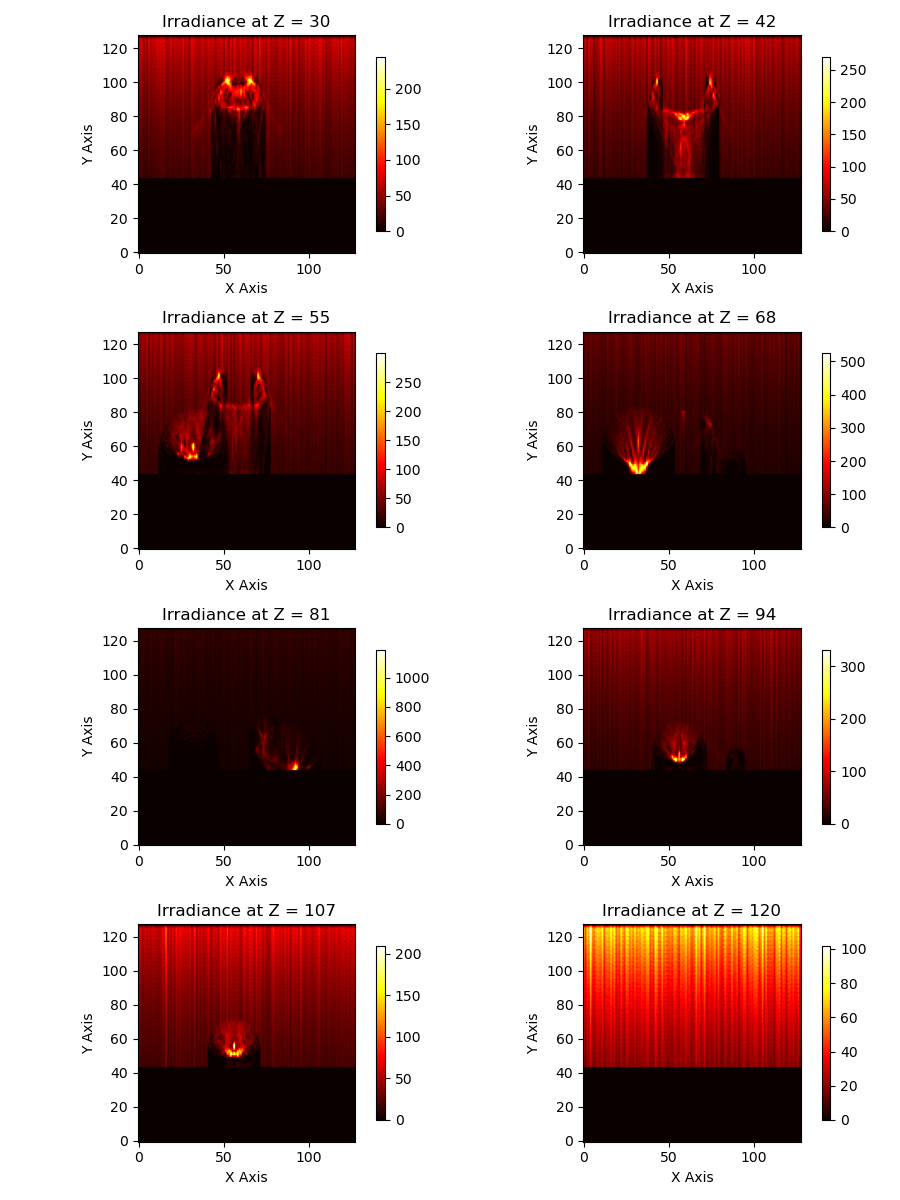

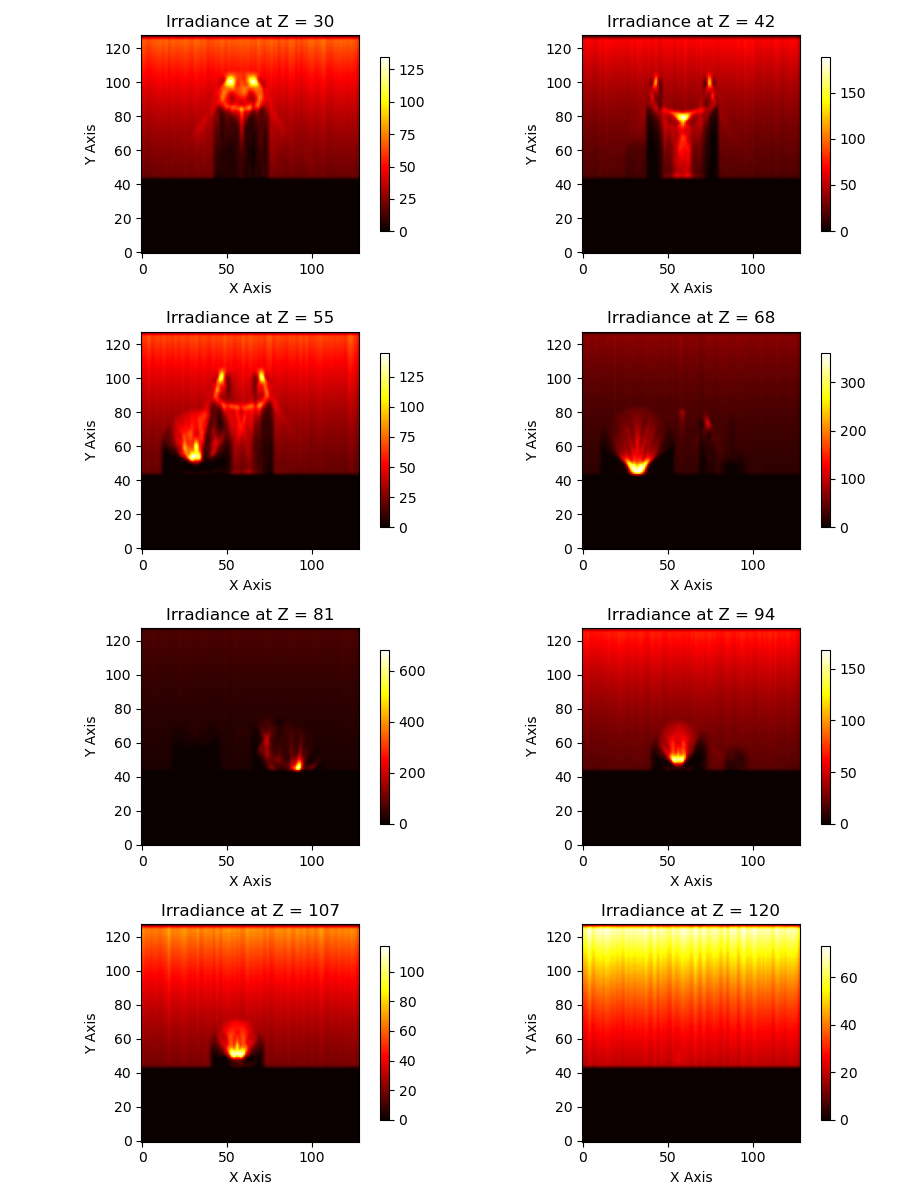

In [6]:
plotter.plot_irradiance_slices(raw_irradiance, threshold=3, num_slices=8, z_start=30, z_end=120)
plotter.plot_irradiance_slices(scene.irradiance, threshold=3, num_slices=8, z_start=30, z_end=120)

## 4. Store irradiance in Neural network irradiance （MLP）

In [7]:
mlp = MLP(scene.irradiance, floor_height, (NUM_X, NUM_Y, NUM_Z))
mlp.train(num_epochs=20)

Inputs shape: (1376256, 3) ; Targets shape: torch.Size([1376256])
Device: cuda
Epoch [5/20], Train Loss: 62.5082, Val Loss: 105.6489
Epoch [10/20], Train Loss: 62.4963, Val Loss: 83.5829
Epoch [15/20], Train Loss: 50.0817, Val Loss: 59.1049
Epoch [20/20], Train Loss: 52.7326, Val Loss: 70.5052


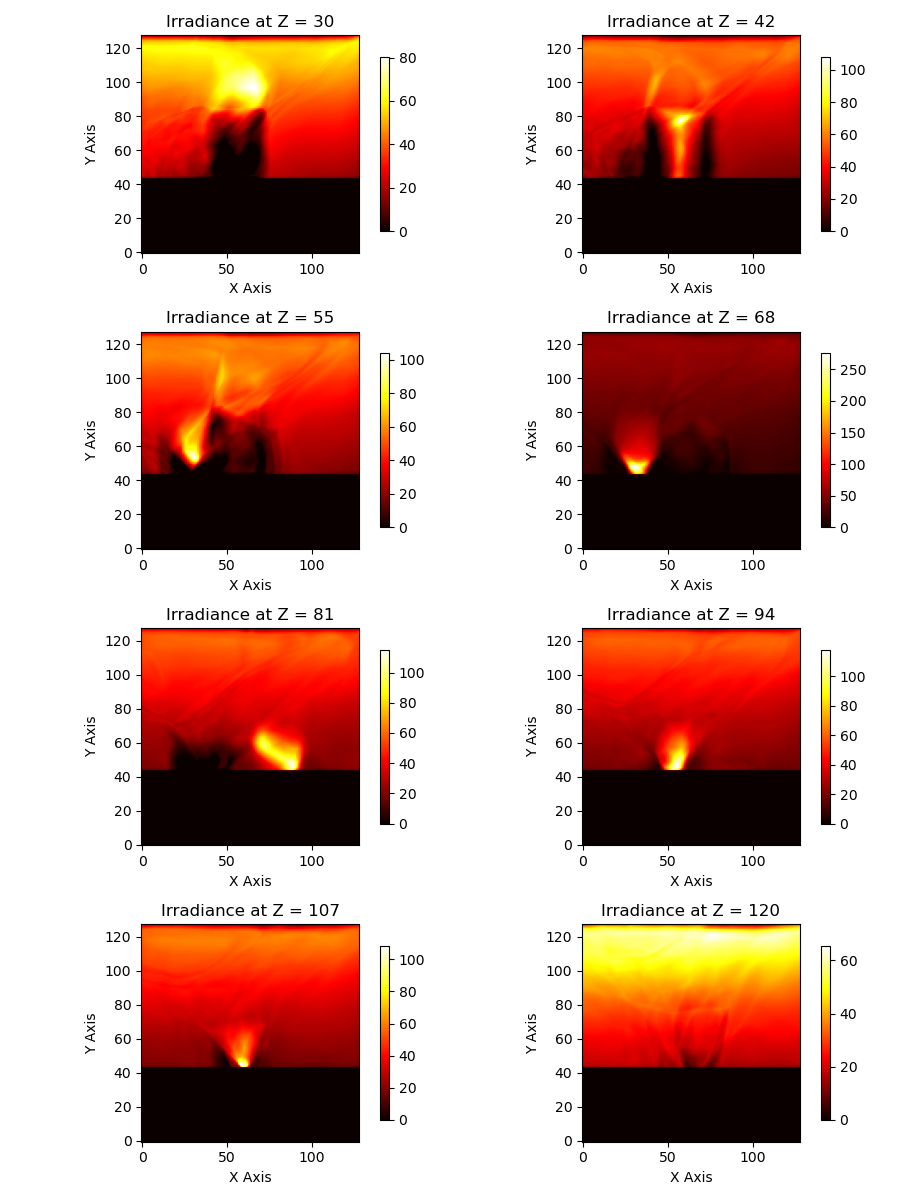

In [8]:
# Visualize the predicted irradiance field
predicted_irradiance = mlp.predict(pad=True)
plotter.plot_irradiance_slices(predicted_irradiance.cpu().numpy(), threshold=3, 
                               num_slices=8, z_start=30, z_end=120)

## 5. Store irradiance in octree

Number of nodes: 118241
Octree Memory usage: 6621496 bytes
In comparison, NumPy Storage Usage: 8388608 bytes


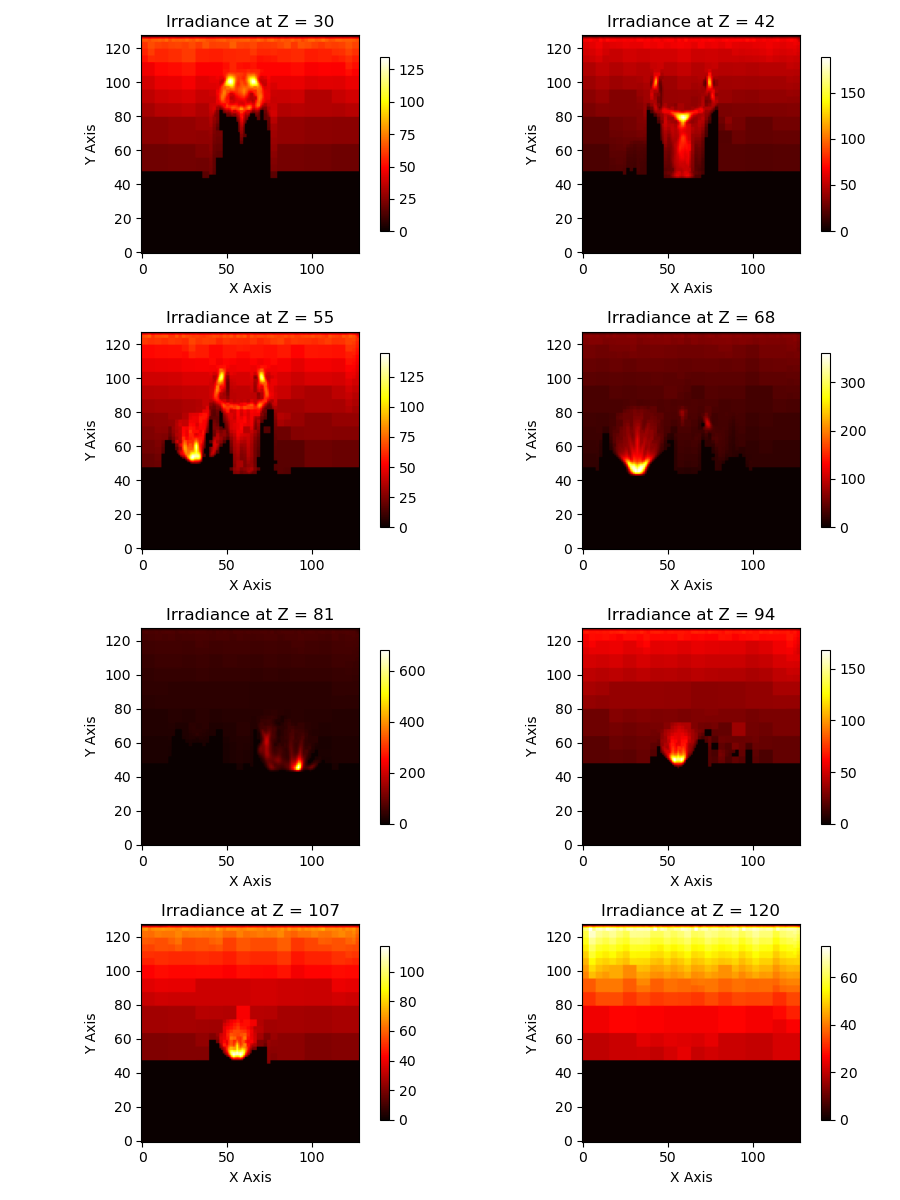

In [9]:
octree = Octree(threshold=int(0.6 * (sampler_multiplier**3)))
octree.construct(scene.irradiance)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {scene.irradiance.nbytes} bytes")
octree.visualize(plotter)

In [10]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

4.4188943

## 6. Ray marching render